In [2]:
# Cell A: imports and settings
import numpy as np
import torch
import torch.nn as nn
from scipy import stats
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math
import random

# reproducibility
RND = 42
np.random.seed(RND)
torch.manual_seed(RND)
random.seed(RND)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [3]:
# Cell B: load & split the Diabetes dataset (train / calib / test)
data = load_diabetes()
X_all = data["data"]      # shape (n_samples, n_features)
y_all = data["target"]    # regression target (continuous)

# splits: 60% train, 20% calib, 20% test
X_tmp, X_test, y_tmp, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=RND)
X_train, X_calib, y_train, y_calib = train_test_split(X_tmp, y_tmp, test_size=0.25, random_state=RND)

# standardize features using training statistics (important for neural nets)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_calib = scaler.transform(X_calib)
X_test = scaler.transform(X_test)

# convert to float32 for PyTorch
X_train = X_train.astype(np.float32)
X_calib  = X_calib.astype(np.float32)
X_test   = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_calib = y_calib.astype(np.float32)
y_test = y_test.astype(np.float32)

print("Sizes -> train:", X_train.shape, "calib:", X_calib.shape, "test:", X_test.shape)

Sizes -> train: (264, 10) calib: (89, 10) test: (89, 10)


In [4]:
# Cell C: helper - pinball loss (quantile loss)
def pinball_loss_torch(preds, targets, tau):
    """
    preds, targets: torch tensors
    tau: scalar in (0,1)
    Returns mean pinball loss (positive)
    """
    diff = targets - preds
    loss = torch.where(diff >= 0, tau * diff, (tau - 1.0) * diff)
    return loss.mean()

In [5]:
# Cell D: define a small MLP for quantile regression
class QuantileMLP(nn.Module):
    def __init__(self, in_dim, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)  # return shape (batch,)

In [6]:
# Cell E: training function for a given tau
def train_quantile_net(X_tr, y_tr, X_val=None, y_val=None,
                       tau=0.5, epochs=200, batch_size=64, lr=1e-3, verbose=False):
    """
    Trains a QuantileMLP to estimate quantile tau.
    Returns the trained model.
    """
    in_dim = X_tr.shape[1]
    model = QuantileMLP(in_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    dataset = TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    for ep in range(epochs):
        model.train()
        epoch_losses = []
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = model(xb)
            loss = pinball_loss_torch(preds, yb, tau)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        if verbose and (ep % 50 == 0 or ep == epochs-1):
            avg = np.mean(epoch_losses)
            msg = f"Epoch {ep+1}/{epochs} - train pinball (tau={tau}): {avg:.4f}"
            if X_val is not None:
                model.eval()
                with torch.no_grad():
                    val_preds = model(torch.from_numpy(X_val).to(device))
                    val_loss = pinball_loss_torch(val_preds, torch.from_numpy(y_val).to(device), tau).item()
                msg += f" | val pinball: {val_loss:.4f}"
            print(msg)
    return model

In [7]:
# Cell F: train two nets for lower and upper quantiles
alpha = 0.05                   # desired miscoverage -> 1-alpha = 0.95 nominal
tau_low = 0.025                # lower conditional quantile to model
tau_high = 0.975               # upper conditional quantile to model

# train them (modest epochs so it runs fast; increase epochs for better fit)
model_low = train_quantile_net(X_train, y_train, X_val=X_calib, y_val=y_calib,
                               tau=tau_low, epochs=300, batch_size=64, lr=1e-3, verbose=True)
model_high = train_quantile_net(X_train, y_train, X_val=X_calib, y_val=y_calib,
                                tau=tau_high, epochs=300, batch_size=64, lr=1e-3, verbose=True)

Epoch 1/300 - train pinball (tau=0.025): 3.7227 | val pinball: 4.1254
Epoch 51/300 - train pinball (tau=0.025): 2.3363 | val pinball: 2.6251
Epoch 101/300 - train pinball (tau=0.025): 2.1141 | val pinball: 2.4447
Epoch 151/300 - train pinball (tau=0.025): 2.0208 | val pinball: 2.4303
Epoch 201/300 - train pinball (tau=0.025): 1.9745 | val pinball: 2.4039
Epoch 251/300 - train pinball (tau=0.025): 2.0121 | val pinball: 2.3865
Epoch 300/300 - train pinball (tau=0.025): 2.0050 | val pinball: 2.3398
Epoch 1/300 - train pinball (tau=0.975): 148.0075 | val pinball: 160.9402
Epoch 51/300 - train pinball (tau=0.975): 7.2884 | val pinball: 9.1408
Epoch 101/300 - train pinball (tau=0.975): 5.1690 | val pinball: 6.2506
Epoch 151/300 - train pinball (tau=0.975): 4.3185 | val pinball: 5.8018
Epoch 201/300 - train pinball (tau=0.975): 4.0619 | val pinball: 5.0430
Epoch 251/300 - train pinball (tau=0.975): 3.6569 | val pinball: 4.4601
Epoch 300/300 - train pinball (tau=0.975): 3.2856 | val pinball: 4

In [8]:
# Cell G: get quantile predictions on calibration and test sets
model_low.eval(); model_high.eval()
with torch.no_grad():
    q_calib_low = model_low(torch.from_numpy(X_calib).to(device)).cpu().numpy()
    q_calib_high = model_high(torch.from_numpy(X_calib).to(device)).cpu().numpy()
    q_test_low = model_low(torch.from_numpy(X_test).to(device)).cpu().numpy()
    q_test_high = model_high(torch.from_numpy(X_test).to(device)).cpu().numpy()
    # for diagnostics, median via training another tau=0.5 net could be used; we will approximate it by (low+high)/2
    q_test_median_approx = 0.5 * (q_test_low + q_test_high)

In [9]:
# Cell H: conformal calibration (finite-sample rank correction)
# nonconformity scores on calibration set
nonconformity_calib = np.maximum(q_calib_low - y_calib, y_calib - q_calib_high)

n_cal = len(nonconformity_calib)
k = math.ceil((n_cal + 1) * (1 - alpha))    # finite-sample rank index
sorted_scores = np.sort(nonconformity_calib)
q_conformal = sorted_scores[k - 1] if k <= n_cal else sorted_scores[-1]
print("Conformal additive correction q_conformal =", q_conformal)

# Apply conformal correction to test intervals
interval_lower = q_test_low - q_conformal
interval_upper = q_test_high + q_conformal
interval_widths = interval_upper - interval_lower

# Evaluate
coverage = np.mean((y_test >= interval_lower) & (y_test <= interval_upper))
avg_width = interval_widths.mean()
mse_med = mean_squared_error(y_test, q_test_median_approx)
print(f"Empirical coverage: {coverage:.3f} (target {1-alpha:.3f})")
print(f"Average interval width: {avg_width:.3f}; median-MSE approx: {mse_med:.3f}")

Conformal additive correction q_conformal = 12.721207
Empirical coverage: 0.966 (target 0.950)
Average interval width: 214.613; median-MSE approx: 3576.459


In [10]:
# Cell I: pinball losses and diagnostics
def pinball_np(y_true, y_pred, tau):
    diff = y_true - y_pred
    loss = np.where(diff >= 0, tau * diff, (tau - 1.0) * diff)
    return loss.mean()

pl_low = pinball_np(y_test, q_test_low, tau_low)
pl_high = pinball_np(y_test, q_test_high, tau_high)
print(f"Pinball losses (test) -> tau_low={tau_low}: {pl_low:.4f}, tau_high={tau_high}: {pl_high:.4f}")

Pinball losses (test) -> tau_low=0.025: 2.5209, tau_high=0.975: 3.2125


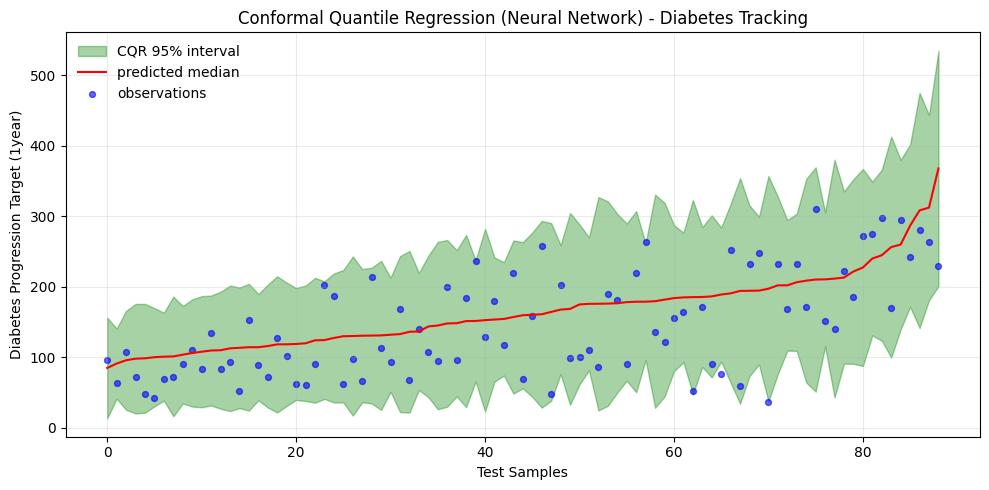

In [11]:
# Cell J: professional plot - use sample index sorted by median prediction for smooth band
sort_idx = np.argsort(q_test_median_approx)
x_axis = np.arange(len(q_test_median_approx))

plt.figure(figsize=(10,5))
plt.fill_between(x_axis, interval_lower[sort_idx], interval_upper[sort_idx],
                 color="green", alpha=0.35, label=f"CQR 95% interval")
plt.plot(x_axis, q_test_median_approx[sort_idx], color="red", linewidth=1.5, label="predicted median ")
plt.scatter(x_axis, y_test[sort_idx], s=18, color="blue", alpha=0.6, label="observations")
plt.xlabel("Test Samples")
plt.ylabel("Diabetes Progression Target (1year)")
plt.title("Conformal Quantile Regression (Neural Network) - Diabetes Tracking")
plt.legend(frameon=False)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.savefig("static_CQR_Plots/nn_diabetes_CQR.png", dpi=600)
plt.show()

Prediction Quality Metrics:
  MSE  = 3576.46
  RMSE = 59.80
  MAE  = 49.95
  Corr = 0.634
  slope = 0.462


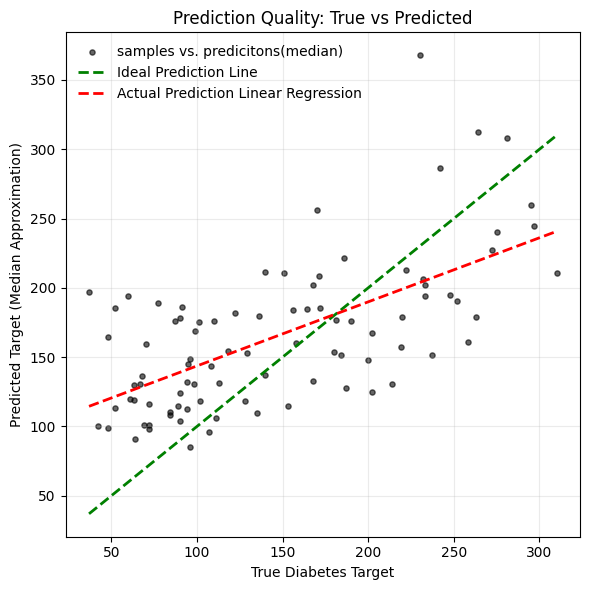

In [12]:
# Cell K: Evaluate predictive accuracy of the model (how well it predicts)

# scatter: true vs predicted (median or actual tau=0.5 model)
y_pred = q_test_median_approx  # use median approximation for now

# compute metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test - y_pred))
corr = np.corrcoef(y_test, y_pred)[0,1]

slope, intercept, r_value, p_value, std_err = stats.linregress(y_test, y_pred)
regression_line = slope * y_test + intercept

print("Prediction Quality Metrics:")
print(f"  MSE  = {mse:.2f}")
print(f"  RMSE = {rmse:.2f}")
print(f"  MAE  = {mae:.2f}")
print(f"  Corr = {corr:.3f}")
print(f"  slope = {slope:.3f}")


# Plot: predicted vs true
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, color="black", s=14, alpha=0.6,
            label="samples vs. predicitons(median)")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'g--', linewidth=2, label="Ideal Prediction Line")
plt.plot([y_test.min(), y_test.max()],
         [regression_line.min(), regression_line.max()],
         'r--', linewidth=2, label="Actual Prediction Linear Regression")
plt.xlabel("True Diabetes Target")
plt.ylabel("Predicted Target (Median Approximation)")
plt.title("Prediction Quality: True vs Predicted")
plt.legend(frameon=False)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.savefig("static_CQR_Plots/nn_true_VS_predicted.png", dpi=600)
plt.show()